In [ ]:
!pip install torch torchvision scikit-learn pandas --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess data
df = pd.read_csv('HOUSEHOLD_E-WASTE_ENV_RISK.csv')
target = 'Risk_Level'

le = LabelEncoder()
df[target] = le.fit_transform(df[target])
y = df[target].values

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != target]
df = pd.get_dummies(df, columns=cat_cols)

X = df.drop(columns=[target])
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define model
class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = SimpleNet(X_train.shape[1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/50 - Loss: {loss.item():.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    outputs = model(X_test_tensor)
    preds = torch.argmax(outputs, axis=1).cpu().numpy()

print("PyTorch DL Accuracy:", accuracy_score(y_test, preds))


Epoch 1/50 - Loss: 0.8159
Epoch 2/50 - Loss: 1.1459
Epoch 3/50 - Loss: 0.6866
Epoch 4/50 - Loss: 0.4836
Epoch 5/50 - Loss: 0.4887
Epoch 6/50 - Loss: 0.4287
Epoch 7/50 - Loss: 0.2329
Epoch 8/50 - Loss: 0.4417
Epoch 9/50 - Loss: 0.1281
Epoch 10/50 - Loss: 0.1794
Epoch 11/50 - Loss: 0.0981
Epoch 12/50 - Loss: 0.2485
Epoch 13/50 - Loss: 0.0809
Epoch 14/50 - Loss: 0.1018
Epoch 15/50 - Loss: 0.1116
Epoch 16/50 - Loss: 0.0445
Epoch 17/50 - Loss: 0.0672
Epoch 18/50 - Loss: 0.1790
Epoch 19/50 - Loss: 0.0448
Epoch 20/50 - Loss: 0.0065
Epoch 21/50 - Loss: 0.0774
Epoch 22/50 - Loss: 0.0136
Epoch 23/50 - Loss: 0.0199
Epoch 24/50 - Loss: 0.0172
Epoch 25/50 - Loss: 0.0189
Epoch 26/50 - Loss: 0.0209
Epoch 27/50 - Loss: 0.0464
Epoch 28/50 - Loss: 0.0528
Epoch 29/50 - Loss: 0.0374
Epoch 30/50 - Loss: 0.0182
Epoch 31/50 - Loss: 0.0214
Epoch 32/50 - Loss: 0.0300
Epoch 33/50 - Loss: 0.0080
Epoch 34/50 - Loss: 0.0406
Epoch 35/50 - Loss: 0.0060
Epoch 36/50 - Loss: 0.0185
Epoch 37/50 - Loss: 0.0062
Epoch 38/5

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    outputs = model(X_test_tensor)
    preds = torch.argmax(outputs, axis=1).cpu().numpy()

# Accuracy
print("PyTorch DL Accuracy:", accuracy_score(y_test, preds))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=le.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))


PyTorch DL Accuracy: 0.9512195121951219

Classification Report:
              precision    recall  f1-score   support

        High       0.80      1.00      0.89        16
         Low       0.91      1.00      0.95        21
    Moderate       1.00      0.93      0.96        86

    accuracy                           0.95       123
   macro avg       0.90      0.98      0.94       123
weighted avg       0.96      0.95      0.95       123


Confusion Matrix:
[[16  0  0]
 [ 0 21  0]
 [ 4  2 80]]


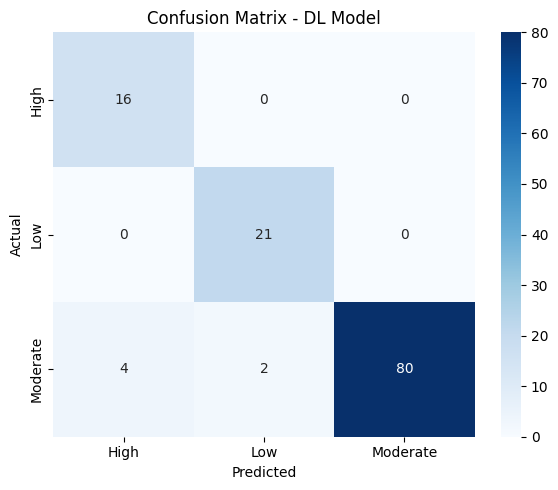

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)
labels = le.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DL Model')
plt.tight_layout()
plt.show()
